# Analysis of Groundtruth Biases

## Preamble

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats.contingency import expected_freq
from scipy.stats import fisher_exact

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12

## Load Data

In [5]:
FILE_FEATURES = '../../data/corpus-validity/wdvc15_features.csv'
FILE_ANNOTATION = '../../data/corpus-validity/wdvc15_annotations.csv'

In [6]:
OUTPUT_DIR = '../../data/classification/'

In [7]:
usecols = ['revisionId', 'selected', 'timestamp', 'registeredUser', 'rollbackReverted']
df_load = pd.read_csv(FILE_FEATURES, index_col=0, usecols=usecols)
df_load['vandalismManual'] = pd.read_csv(FILE_ANNOTATION, index_col=0)
df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])

## Biases by Wikidata Reviewers

In [8]:
df = df_load[(df_load['selected'] == 'rollback') | (df_load['selected'] == 'inconspicuous')]
df = df[~df['vandalismManual']]
ct_observed = pd.crosstab(df['registeredUser'], df['rollbackReverted']).iloc[:, ::-1]
ct_expected = ct_observed.copy()
ct_expected.loc[:, :] = expected_freq(ct_observed.values)
table = pd.concat([ct_observed, ct_expected], axis=1, keys=['Observed', 'Expected'])

formatters = {
    ('Expected', True): '{:.1f}'.format,
    ('Expected', False): '{:.1f}'.format
}

table.to_latex(OUTPUT_DIR + 'table-bias-reviewers.tex', formatters=formatters)
table.style.format(formatters)

fisher_exact(ct_observed.values)[1]

1.11171829124334e-86

## Reviewer Bias over Time

In [9]:
df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])

In [10]:
def plot_reviewer_bias_over_time(ax, df_odds_ratio):
    # define colors
    odds_color = '#800080'
    revision_color = 'xkcd:light grey'
    revision_color2 = 'xkcd:black'

    # init
    xticks = np.arange(0, len(df_odds_ratio))

    # odds ratio
    ax.plot(xticks, df_odds_ratio['odds_ratio'].values, marker='o',
            color=odds_color, label='Odds ratio');
    ax.tick_params(axis='y', labelcolor=odds_color);
    ax.set_xticks(xticks);
    ax.set_xticklabels(df_odds_ratio.index);
    ax.set_ylabel('Odds ratio', color=odds_color);
    ax.set_yscale('log')
    ax.fill_between(xticks, df_odds_ratio['ci_start'], df_odds_ratio['ci_end'], interpolate=True,
                    color=odds_color, alpha=0.4, label='95% CI')

    # revisions
    ax2 = ax.twinx()
    ax2.bar(xticks, df_odds_ratio['n_revisions'].values,
            color=revision_color, label='Edit bins');
    ax2.tick_params(axis='y', labelcolor=revision_color2);
    ax2.set_ylabel('Number of edits', color=revision_color2);
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(50))

    # z order
    ax.set_zorder(ax2.get_zorder() + 1);
    ax.patch.set_visible(False);

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles + handles2, labels + labels2, loc='upper left')

    return fig

In [11]:
def compute_odds_ratio(ct):
    return ct.iloc[0, 0] / ct.iloc[0, 1] / (ct.iloc[1, 0] / ct.iloc[1, 1])


def format_datetime(datetime):
    return datetime.strftime('%m/%y')


def format_index(df):
    start = format_datetime(df.index[0])
    end = format_datetime(df.index[-1])
    return '{} - {}'.format(start, end)

In [12]:
def get_CI(odds_ratio, ct):
    SE_ln_odds_ratio = math.sqrt((1 / ct.values).sum())
    start = math.exp(math.log(odds_ratio) - 1.96 * SE_ln_odds_ratio)
    end   = math.exp(math.log(odds_ratio) + 1.96 * SE_ln_odds_ratio)
    return start, end

In [13]:
import matplotlib.ticker as ticker

In [14]:
df = df_load[(df_load['selected'] == 'rollback') | (df_load['selected'] == 'inconspicuous')].sort_index()
df = df[~df['vandalismManual']]
df.set_index('timestamp', inplace=True)

df_odds_ratio = pd.DataFrame()

step_size = round(len(df) / 4)
for i in range(0, len(df) - 1, step_size):
    df1 = df.iloc[i: i + step_size]
    ct = pd.crosstab(df1['registeredUser'], df1['rollbackReverted']).iloc[:, ::-1]
    odds_ratio = compute_odds_ratio(ct)
    ci_start, ci_end = get_CI(odds_ratio, ct)
    index = format_index(df1)
    df_odds_ratio.loc[index, 'odds_ratio'] = odds_ratio
    df_odds_ratio.loc[index, 'ci_start'] = ci_start
    df_odds_ratio.loc[index, 'ci_end'] = ci_end
    df_odds_ratio.loc[index, 'n_revisions'] = ct.values.sum()

df_odds_ratio

,odds_ratio,ci_start,ci_end,n_revisions
10/12 - 08/13,53.777778,17.849343,162.025539,276.0
08/13 - 05/14,31.857143,13.517772,75.077279,276.0
05/14 - 08/14,277.150000,57.239413,1341.944630,276.0
08/14 - 11/14,1243.142857,148.729503,10390.703460,275.0


In [15]:
len(df)

1103

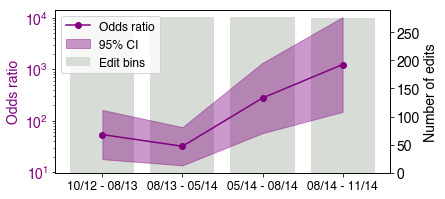

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))
fig = plot_reviewer_bias_over_time(ax, df_odds_ratio)
fig.savefig(OUTPUT_DIR + 'plot-reviewer-bias-over-time.pdf', transparent=True, bbox_inches='tight')